# Fishing Effort in the Berents

In [1]:
import bq  
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib
from matplotlib import colors,colorbar
import matplotlib
%matplotlib inline
import csv 
import math
from math import radians, cos, sin, asin, sqrt
from scipy import stats
import matplotlib.dates as mdates

client = bq.Client.Get()

/Users/David/Desktop/Jobs/GlobalFishingWatch/github/vessel-maps/utilities/pipa_paper/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [20]:
# create a bounding box:
max_lat = 82
min_lat = 68
max_lon = 54
min_lon = 16

In [21]:
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer

In [22]:
q = '''
select count(distinct mmsi) 
FROM
  [tilesets.pipeline_2015_08_24_08_19_01]
WHERE
  latitude > '''+str(min_lat)+'''
  AND latitude <'''+str(max_lat)+'''
  AND longitude > '''+str(min_lon)+'''
  AND longitude < '''+str(max_lon)+'''
  AND weight >=.5'''

number_of_mmsi = Query(q)

Waiting on bqjob_r252e375b306b77ca_0000015434c2414e_8 ... (2s) Current status: DONE   
Query time: 4.58446598053 seconds.


In [23]:
print "Number of unique MMSI:",int(number_of_mmsi[0][0])

Number of unique MMSI: 1165


# 1151 MMSI were fishing in this region from January 2014 to July 2015

In [24]:
q = '''
select a.mmsi mmsi,
a.number number,
if(b.country is null, "invalid mmsi",b.country) country,
b.continent continent
from
(select mmsi, 
integer(if(length(string(mmsi))= 9,LEFT(STRING(mmsi),3), '0')) code,
count(*) number from
(SELECT
  mmsi,
  date(timestamp) date,
  first(latitude) lat,
  first(longitude) lon
FROM
  [tilesets.pipeline_2015_08_24_08_19_01]
WHERE
  latitude > '''+str(min_lat)+'''
  AND latitude <'''+str(max_lat)+'''
  AND longitude > '''+str(min_lon)+'''
  AND longitude < '''+str(max_lon)+'''
  AND weight >=.5
group by mmsi, date) 
group by mmsi, code 
) 
a
left join [scratch_roan.country_code] b
on a.code = b.code 
order by number desc'''

days_by_mmsi = Query(q)

Waiting on bqjob_r2eaa1bfde877409d_0000015434c25343_9 ... (2s) Current status: DONE   
Query time: 4.46662902832 seconds.


# The List of MMSI that were fishing are below

In [25]:
for r in days_by_mmsi:
    if "Taiwan" in r[2]:
        r[2] = "Taiwan"
    print "mmsi:", r[0],"  fishing days:", r[1], "  country: ", r[2].split(" (")[0]

mmsi: 273412090   fishing days: 557   country:  Russian Federation
mmsi: 257490700   fishing days: 550   country:  Norway
mmsi: 273313560   fishing days: 538   country:  Russian Federation
mmsi: 257312540   fishing days: 533   country:  Norway
mmsi: 273510600   fishing days: 531   country:  Russian Federation
mmsi: 273290400   fishing days: 530   country:  Russian Federation
mmsi: 259635000   fishing days: 522   country:  Norway
mmsi: 273516500   fishing days: 521   country:  Russian Federation
mmsi: 273853400   fishing days: 511   country:  Russian Federation
mmsi: 273559500   fishing days: 506   country:  Russian Federation
mmsi: 258185000   fishing days: 505   country:  Norway
mmsi: 273312270   fishing days: 493   country:  Russian Federation
mmsi: 257030600   fishing days: 492   country:  Norway
mmsi: 273433400   fishing days: 488   country:  Russian Federation
mmsi: 251222540   fishing days: 485   country:  Iceland
mmsi: 273212500   fishing days: 484   country:  Russian Federation

In [26]:
# Now Group by Country
q = '''
SELECT 
country,
sum(number) number
from
(select a.mmsi mmsi,
a.number number,
if(b.country is null, "invalid mmsi",b.country) country,
b.continent continent
from
(select mmsi, 
integer(if(length(string(mmsi))= 9,LEFT(STRING(mmsi),3), '0')) code,
count(*) number from
(SELECT
  mmsi,
  date(timestamp) date,
  first(latitude) lat,
  first(longitude) lon
FROM
  [tilesets.pipeline_2015_08_24_08_19_01]
WHERE
  latitude > '''+str(min_lat)+'''
  AND latitude <'''+str(max_lat)+'''
  AND longitude > '''+str(min_lon)+'''
  AND longitude < '''+str(max_lon)+'''
  AND weight >=.5
group by mmsi, date) 
group by mmsi, code 
) 
a
left join [scratch_roan.country_code] b
on a.code = b.code)
group by country
order by number desc'''

country_groups = Query(q)

Waiting on bqjob_rff9f1bef0215549_0000015434c264e8_10 ... (3s) Current status: DONE   
Query time: 5.40917086601 seconds.


In [27]:
print "days\tcountry"
for c in country_groups:
    print c[1],'\t', c[0].split(" (")[0]

days	country
80096 	Norway
36251 	Russian Federation
1898 	Faroe Islands - Denmark
1427 	Iceland
1301 	Spain
1161 	Lithuania
629 	Estonia
593 	Latvia
412 	Greenland - Denmark
349 	United Kingdom of Great Britain and Northern Ireland
223 	Poland
196 	Germany
182 	invalid mmsi
160 	Denmark
139 	France
54 	Portugal
48 	Ireland
45 	Sweden
42 	Netherlands
27 	Sierra Leone
26 	Croatia
20 	Greece
16 	Italy
4 	Argentine Republic
2 	Malta
2 	China
1 	Canada
1 	Turkey
1 	United States of America
1 	Finland


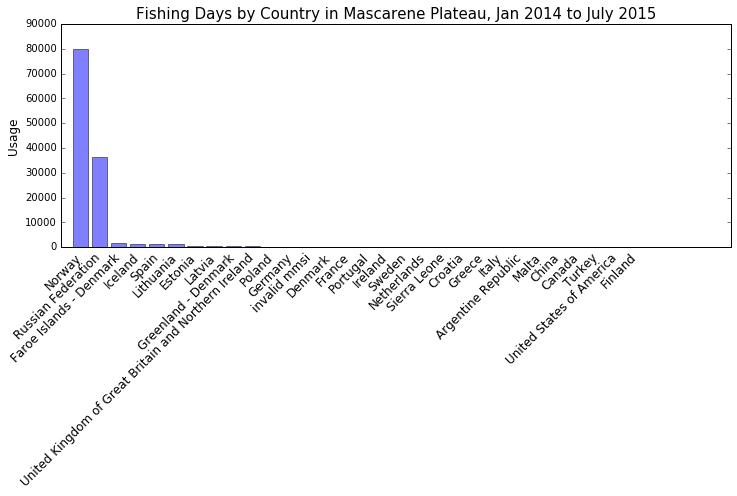

In [28]:
objects = [c[0].split(" (")[0] for c in country_groups]
y_pos = np.arange(len(objects))
performance = [c[1] for c in country_groups]
 
plt.figure(figsize=(12,4))
plt.bar(y_pos-4, performance, align='center', alpha=0.5,)
plt.xticks(y_pos-4+.2, objects, fontsize=12) # rotation=45
locs, labels = plt.xticks()
plt.setp(labels, rotation=45,ha='right')
plt.ylabel('Usage',fontsize=12)
plt.title('Fishing Days by Country in Mascarene Plateau, Jan 2014 to July 2015',fontsize=15)

ax = plt.axes()
ax.xaxis.set_ticks_position('none') 
plt.savefig("fishing_effort_mascarene_by_Country.png",bbox_inches='tight',dpi=150,transparent=True,pad_inches=.1)
plt.show()

# Map the Fishing Effort in This Region

In [29]:
# Now Group by Country
q = '''
SELECT
lat,
lon,
count(*) fishing_days
from
(SELECT
  mmsi,
  date(timestamp) date,
  integer(first(latitude)*4) lat,
  integer(first(longitude)*4) lon
FROM
  [tilesets.pipeline_2015_08_24_08_19_01]
WHERE
  latitude > '''+str(min_lat)+'''
  AND latitude <'''+str(max_lat)+'''
  AND longitude > '''+str(min_lon)+'''
  AND longitude < '''+str(max_lon)+'''
  AND weight >=.5
group by mmsi, date) 
group by lat, lon
'''

fishing_grid = Query(q)

Waiting on bqjob_r4ad3af582b718a54_0000015434c27df7_11 ... (2s) Current status: DONE   
Query time: 4.65414690971 seconds.


In [30]:
cellsize = .25
one_over_cellsize = 4

num_lats = (max_lat-min_lat)*one_over_cellsize+1
num_lons = (max_lon-min_lon)*one_over_cellsize+1


grid = np.zeros(shape=(num_lats,num_lons))

for row in fishing_grid:
    lat = int(row[0])
    lon = int(row[1])
    lat_index = lat-min_lat*one_over_cellsize
    lon_index = lon-min_lon*one_over_cellsize
    grid[lat_index][lon_index] = int(row[2])

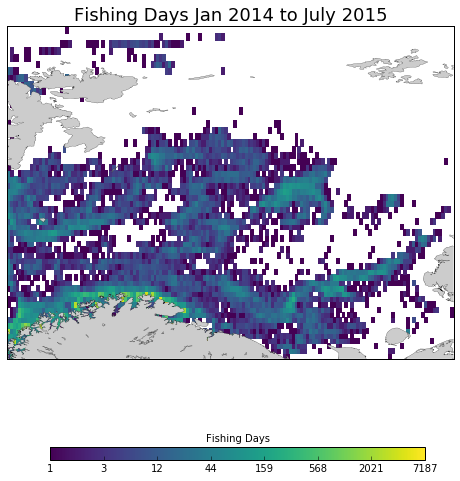

In [32]:
plt.rcParams["figure.figsize"] = [8,9]

firstlat = max_lat
lastlat =  min_lat
firstlon = min_lon
lastlon = max_lon
scale = cellsize

numlats = int((firstlat-lastlat)/scale+.5)
numlons = int((lastlon-firstlon)/scale+.5)
    
lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

fig = plt.figure()
extra = 0
m = Basemap(llcrnrlat=lastlat-extra, urcrnrlat=firstlat+extra,
          llcrnrlon=firstlon-extra, urcrnrlon=lastlon+extra, lat_ts=0, projection='mill',resolution="h")

m.drawmapboundary()#fill_color='#111111')
m.drawcoastlines(linewidth=.2)
m.fillcontinents('#cccccc',lake_color='#cccccc')#, lake_color, ax, zorder, alpha)

x = np.linspace(firstlon, lastlon, -(firstlon-lastlon)*one_over_cellsize+1)
y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize+1)
x, y = np.meshgrid(x, y)
converted_x, converted_y = m(x, y)
from matplotlib import colors,colorbar

maximum = grid.max()
minimum = 1

norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)

m.pcolormesh(converted_x, converted_y, grid, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))

t = "Fishing Days Jan 2014 to July 2015"
plt.title(t, color = "#000000", fontsize=18)

ax = fig.add_axes([0.2, 0.1, 0.65, 0.02]) #x coordinate , 
norm = colors.LogNorm(vmin=minimum, vmax=maximum)
# norm = colors.Normalize(vmin=0, vmax=1000)
lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))

#cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
cb.ax.set_xticklabels([int(i) for i in lvls], fontsize=10, color = "#000000")
cb.set_label('Fishing Days',labelpad=-40, y=0.45, color = "#000000")
plt.savefig("fishing_effort_barents.png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1)
plt.show()